## Comparing both strain sensor on Index MCP angle data and IMU on wrist and palm angle data to camera angle data for any of the APPLIED tests

##  Process flow:  

(1) Load data folder

(2) Plot raw calibrated strain sensor on index MCP which was placed on Phil's angle calibration block

(3) Pick data segments (by index) from plot above for each bend angle to build the calibration curve

(4) Sanity check: compare the quadratic ADC–angle fit against the theoretical model.

(5) Apply the quadratic calibration to convert all trial ADC values to angles

(6) Example for how to plot single trial for 1st application and reapplication

(7) Plot all trials together for 1st application and reapplication

(8) Get per-trial camera timestamp tables from flir.mat (prefix 'ts*')

(9) Match trial ADC timestamps to camera trigger timestamps -> need for error analysis 

(10) Plot Angle from Strain Sensor vs Row Index AND DLC Angle vs Row Index on same plot

(11) Extract IMU trials (same calls as before)

(12) Compute bend angle from two IMU's and plot

(13) Match trial IMU timestamps to camera trigger timestamps -> need for error analysis

(14) Plot Wrist Angle from IMU's vs Row Index AND DLC Angle vs Row Index on same plot




In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from config import path_to_repository
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4887: SyntaxWarning: invalid escape sequence '\D'
  ax[0].set_ylabel('$\Delta R/R_o$')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:4894: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_ylabel('$\Delta R/R_o$')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:5183: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel('$\Delta R/R_o$', color='b')
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\camera_sensor_imu_analysis\analysis.py:5198: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_xlabel('$\epsilon$ (strain)')


Found 8 *_B_slow folders total (case-insensitive).
  example: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\10_26_25\2025_10_26_16_18_40_B_slow
First set range: 2025_10_26_16_18_40_B_slow → 2025_10_26_16_19_10_B_slow
Second set range: 2025_10_26_16_26_27_B_slow → 2025_10_26_16_27_00_B_slow
[WARN] ball_bearing_first: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_10_26_16_18_40_B_slow has 6 CSVs (including nested)
  • Trial 02: 2025_10_26_16_19_10_B_slow has 6 CSVs (including nested)
First set range: 2025_10_26_16_18_40_B_slow → 2025_10_26_16_19_10_B_slow
Second set range: 2025_10_26_16_26_27_B_slow → 2025_10_26_16_27_00_B_slow
[WARN] ball_bearing_second: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_10_26_16_26_27_B_slow has 6 CSVs (including nested)
  • Trial 02: 2025_10_26_16_27_00_B_slow has 6 CSVs (including nested)
Found 1 *_C_Autobender folders total (case-insensitive).
  example: C:\Users\toppe\OneDrive - CSU Mar

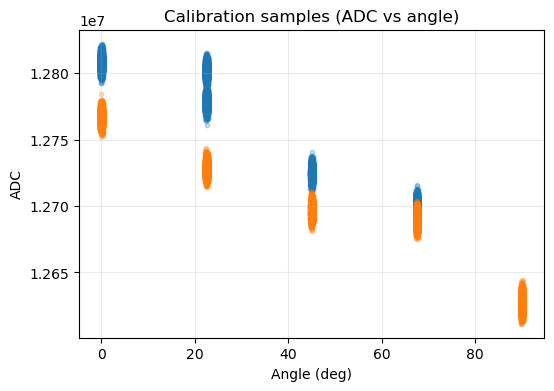

In [5]:
# Upload ball bearing and beaker Trials from particpant
# Upload only the parent *date* folder (e.g., "9_19_25").
# If something fails, verify your folder structure matches the "9_19_25" example.


bb = BallBearingData(
    root_dir="CSV Data/10_26_25", # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=2,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix="B_slow",     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first  = bb.load_first() # first application
df_second = bb.load_second() # reapplication

adc_trials_first = bb.extract_adc_dfs_by_trial(df_first)  # list of DataFrames 
adc_trials_second = bb.extract_adc_dfs_by_trial(df_second)  # list of DataFrames
trial1_adc = adc_trials_first[0]  # trial 1 (index 0)

#######################################################################

# upload  csv files for sensor calibration on autobender.  This was only done twice for Tom.  After Tom's experiments, strain sensor only calibrated on Phil's 
renc = os.path.join(path_to_repository , "CSV Data/10_26_25/2025_10_26_15_19_56_C_Autobender/data_rotenc_2025_10_26_15_19_56_C_Autobender.csv")
strain = os.path.join(path_to_repository , "CSV Data/10_26_25/2025_10_26_15_19_56_C_Autobender/data_adc_2025_10_26_15_19_56_C_Autobender.csv")


# autobender calibration
bb_auto = BallBearingData(
    root_dir="CSV Data/10_26_25", # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=1,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix="C_Autobender",     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first_auto  = bb_auto.load_first() # first application
df_second_auto = bb_auto.load_second() # reapplication

# DataFrames (one per trial) using your class’ finder logic (largest matching file)
auto_path_first  = bb_auto.extract_adc_dfs_by_trial(df_first_auto)
auto_path_second = bb_auto.extract_adc_dfs_by_trial(df_second_auto)


# Efirst autobender calibration
#auto_path_second = auto_path_second[0]
#auto_path_second = auto_path_second["adc_ch3"]

#################################################################################

# block calibration
bb_hand_c = BallBearingData(
    root_dir="CSV Data/10_26_25", # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=1,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix="C_Block",     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first_hand_c  = bb_hand_c.load_first() # first application
df_second_hand_c = bb_hand_c.load_second() # reapplication

# DataFrames (one per trial) using your class’ finder logic (largest matching file)
h_cal_path_first  = bb_hand_c.extract_adc_dfs_by_trial(df_first_hand_c)
h_cal_path_second = bb_hand_c.extract_adc_dfs_by_trial(df_second_hand_c)

# first hand block calibration
h_cal_path_first = h_cal_path_first[0]
h_cal_path_first = h_cal_path_first["adc_ch3"]

# Second hand block calibration
h_cal_path_second = h_cal_path_second[0]
h_cal_path_second = h_cal_path_second["adc_ch3"]


#####################################################################################

bb_cam_c = BallBearingData(
    root_dir="CSV Data/10_26_25",
    path_to_repo=path_to_repository,
    n_trials_per_set=1,
    files_per_trial=7,
    folder_suffix="unused_here",  # not used by this method
)

cam_c_df = bb_cam_c.extract_calib_means_by_set(
    exclude_name_contains=("C_Block",),
    exclude_sets=(3, 4),
    make_plot=True,          # scatter of all samples
    overlay_mean=False,      # don't draw mean lines
    point_alpha=0.25,
    point_size=10,
    jitter=0.25
)


## Plot raw calibrated strain sensor on index MCP which was placed on Phil's angle calibration block

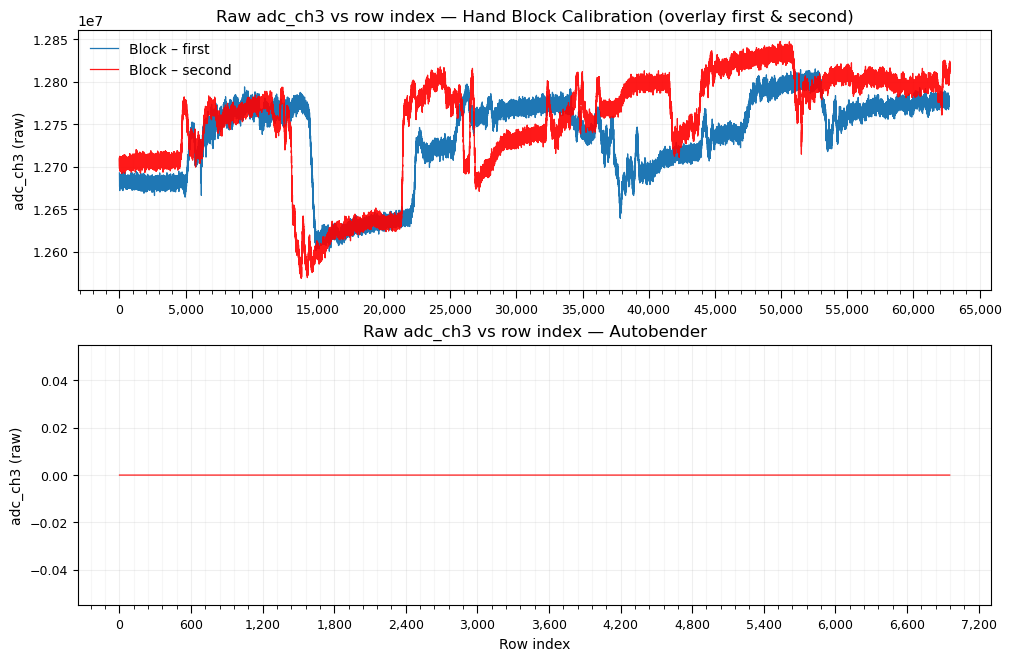

In [7]:
import matplotlib.ticker as mticker

# Autobender strain file
adc_df_auto = pd.read_csv(strain)
y_auto = pd.to_numeric(adc_df_auto["adc_ch3"], errors="coerce")

# Example assuming you already defined these somewhere above
y_block_first  = h_cal_path_first
y_block_second = h_cal_path_second

# --- x-axes ---
x_block_first  = np.arange(len(y_block_first))
x_block_second = np.arange(len(y_block_second))
x_auto         = np.arange(len(y_auto))

# ---- Plot: block (top, overlay first & second) and autobender (bottom) ----
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6.5), sharex=False, constrained_layout=True)

# Top: block calibration, overlay first (blue) + second (red)
ax1.plot(
    x_block_first,
    pd.to_numeric(pd.Series(y_block_first), errors="coerce").values,
    linewidth=0.9,
    label="Block – first",
)
ax1.plot(
    x_block_second,
    pd.to_numeric(pd.Series(y_block_second), errors="coerce").values,
    linewidth=0.9,
    color="red",
    alpha=0.9,
    label="Block – second",
)
ax1.set_title("Raw adc_ch3 vs row index — Hand Block Calibration (overlay first & second)")
ax1.set_ylabel("adc_ch3 (raw)")
ax1.grid(alpha=0.2, which="major")
ax1.grid(alpha=0.1, which="minor", axis="x")
ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15))
ax1.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))
ax1.tick_params(axis="x", which="major", length=6)
ax1.tick_params(axis="x", which="minor", length=3)
ax1.tick_params(axis="both", which="both", labelsize=9)
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v):,}"))
ax1.legend(loc="best", frameon=False)

# Bottom: autobender (red)
ax2.plot(x_auto, y_auto.values, linewidth=0.8, color="red")
ax2.set_title("Raw adc_ch3 vs row index — Autobender")
ax2.set_xlabel("Row index")
ax2.set_ylabel("adc_ch3 (raw)")
ax2.grid(alpha=0.2, which="major")
ax2.grid(alpha=0.1, which="minor", axis="x")
ax2.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15))
ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))
ax2.tick_params(axis="x", which="major", length=6)
ax2.tick_params(axis="x", which="minor", length=3)
ax2.tick_params(axis="both", which="both", labelsize=9)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v):,}"))

plt.show()


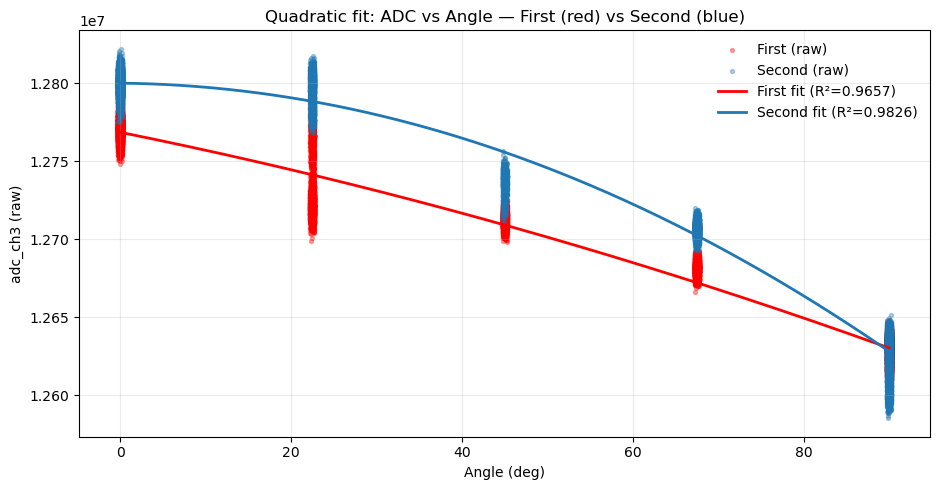

{'c0': 12768602.851197168, 'c1': -1105.0913574248525, 'c2': -4.800395805531261, 'r2': 0.9657236747638618, 'n': 21000} {'c0': 12800087.778921232, 'c1': -56.13242108017476, 'c2': -20.613247475612994, 'r2': 0.9825842986611383, 'n': 19000}


In [8]:
ranges_first = [
    (55000,  62000),    # 0°
    (23000, 26000),   # 22.5°
    (41000,  43000),   # 45°
    (1000,  4000),   # 67.5° was not easy to distiguish from 90 degrees so not used for Phil data
    (15000, 21000),   # 90°
]

ranges_second = [
    (55000,  62000),    # 0°
    (23000, 25000),   # 22.5°
    (42000,  43000),   # 45°
    (1000,  4000),   # 67.5° was not easy to distiguish from 90 degrees so not used for Phil data
    (15000, 21000),   # 90°
]

angles = [0.0, 22.5, 45.0, 67.5, 90.0]

res = bb.compare_block_quadratic_vs_angle(
    h_cal_path_first=h_cal_path_first,   # CSV path or Series/array
    ranges_first=ranges_first,
    h_cal_path_second=h_cal_path_second, # CSV path or Series/array
    ranges_second=ranges_second,
    angles=angles,
    max_points_per_range=None,           # or 200, etc.
)
print(res["first"], res["second"])

## Pick data segments (by index) from plot above for each bend angle to build the calibration curve

## Sanity check: compare the quadratic ADC–angle fit against the theoretical model.

### Strain–Angle Relation

$$
\varepsilon = \alpha \, \theta
$$

where  

$$
\alpha = \frac{c}{L}
$$

and  

$$
\varepsilon = \text{strain} = \frac{\Delta L}{L}, \quad 
c = \text{knuckle radius}, \quad 
L = \text{sample length}
$$

---

### Resistance–Strain Relation

$$
\frac{\Delta R}{R_0}
= \frac{\rho L \varepsilon}{w h R_0}
\left( \frac{8 - \varepsilon}{(2 - \varepsilon)^2} \right)
= k
$$

where  

$$
R_0 = \text{initial resistance}
$$

---

### Normalization $(0 \rightarrow 1)$

$$
\text{norm}_{(0 \rightarrow 1)} =
\frac{k_i - k_{\min}}{k_{\max} - k_{\min}}
=
\frac{
\theta_i (8 - \alpha \theta_i)
\left( (2 - \alpha \pi / 2)^2 \right)
}{
(\pi / 2)(8 - \alpha \pi / 2)(2 - \alpha \theta_i)^2
}
$$

---

### Boundary Conditions

At $\theta_i = \pi/2$:

$$
\text{norm}_{@1} =
\frac{k_i(\theta_i = \pi/2) - 0}{
k_{\max}(\theta_i = \pi/2) - 0
} = 1
$$

At $\theta_i = 0$:

$$
\text{norm}_{@0} =
\frac{k_i(\theta_i = 0) - 0}{
k_{\max}(\theta_i = \pi/2) - 0
} = 0
$$



In [ ]:
# angle_adc_df already built (block selection)
# cam_c_df came from bb_cam_c.extract_calib_means_by_set(...)

# Prepare & fit on BLOCK selection (self.data)
g = bender_class()
g.load_merged_df(angle_adc_df, enc_col="angle", adc_col="adc_ch3")
g.normalize_adc_bw_01()

# Build proper sequences so indices matter (call the helper on the class/object)
cam_seq   = g._coerce_to_df_sequence(cam_c_df)          # now cam_index will actually change data
block_seq = g._coerce_to_df_sequence([angle_adc_df])    # keep API consistent (sequence)

print(f"[debug] camera items: {len(cam_seq)}")
if len(cam_seq) >= 2:
    print("[debug] cam_seq[0] vs cam_seq[1] shapes:",
          cam_seq[0].shape, cam_seq[1].shape)

# Make an axes and pass it into the method (important for legend control)
fig, ax = plt.subplots(figsize=(6.8, 4.3))

res = g.fit_knuckle_radius_from_normalized(
    L=1.65, r0=0.5, plot=True, ax=ax,
    block_df=block_seq,  block_index=0,
    cam_df=cam_seq,      cam_index=0,
    cam_label="Camera calibration",
    block_label="Block calibration",
    cam_angle_col_hint="angle_deg",   # <- explicit for camera DF
    cam_adc_col_hint="mean_adc",      # <- explicit for camera DF
    verbose=True
)

# FORCE the legend to exactly what you want (uses explicit handles)
from matplotlib.lines import Line2D
custom_handles = [
    Line2D([0],[0], color="tab:orange", linewidth=2),                  # theory
    Line2D([0],[0], color="tab:green",  marker='o', linestyle='None'), # block points
    Line2D([0],[0], color="tab:green",  linewidth=2, linestyle="--"),  # block quad
    Line2D([0],[0], color="tab:blue",   marker='o', linestyle='None'), # camera points
    Line2D([0],[0], color="tab:blue",   linewidth=2, linestyle=":"),  # camera quad
]
r2_block = res.get("overlays", {}).get("block", {}).get("r2", float("nan"))
r2_cam   = res.get("overlays", {}).get("cam",   {}).get("r2", float("nan"))

custom_labels = [
    f"Theory fit (r={res['r_hat']:.3f}, R²={res['r2']:.4f})",
    "Block calibration (points)",
    f"Block calibration (quad, R²={r2_block:.4f})",
    "Camera calibration (points)",
    f"Camera calibration (quad, R²={r2_cam:.4f})",
]

ax.legend(custom_handles, custom_labels, loc="best", frameon=True)
plt.tight_layout()
plt.show()


## Apply the quadratic calibration to convert all trial ADC values to angles

In [ ]:
out = bb.calibrate_from_pairs_and_stream(
    angle_adc_df, # block calibration data
    adc_trials_first=adc_trials_first,
    adc_trials_second=adc_trials_second,
    stack_limit=15, q_hi=1, q_lo=0,
    deg_min=0, deg_max=90,
    clip_z=True, extrapolate=True,
    clamp_theta=True, trial_len_sec=10.0,
    verbose=True,
)

theta_all = out["theta_all"]
print(out["anchors"], out["oob_counts"])


## Example for how to plot single trial for 1st application and reapplication

In [ ]:
# Plot first trial for both 1st application (blue) and reapplication (red)
# Need to double check with Phil, but first 15 of each should be ball bearing, 16-30 beaker

# Filter trial 1 from each set
A1 = theta_all[(theta_all["set_label"] == "first")  & (theta_all["trial"] == 1)]
B1 = theta_all[(theta_all["set_label"] == "second") & (theta_all["trial"] == 1)]



fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# Top: FIRST set (blue) – trial 1
if not A1.empty:
    axes[0].plot(A1["time_s"], A1["theta_pred_deg"], ".", markersize=2, color="blue")
axes[0].set_title("Set A (first): Trial 1 — θ_pred vs time")
axes[0].set_ylabel("θ_pred (deg)")
axes[0].grid(alpha=0.25)

# Bottom: SECOND set (red) – trial 1
if not B1.empty:
    axes[1].plot(B1["time_s"], B1["theta_pred_deg"], ".", markersize=2, color="red")
axes[1].set_title("Set B (second): Trial 1 — θ_pred vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_pred (deg)")
axes[1].grid(alpha=0.25)

# Fix y-range and ticks
#axes[0].set_ylim(0, 90)
#axes[1].set_ylim(0, 90)
#axes[0].set_yticks(range(0, 90, 5))
#axes[1].set_yticks(range(0, 90, 5))

plt.tight_layout()
plt.show()



## Plot all trials together for 1st application and reapplication

In [ ]:
# Plotting all 30 trials 1st application and 1st reapplication data here for strain sensor

# Split by set
A = theta_all[theta_all["set_label"] == "first"]
B = theta_all[theta_all["set_label"] == "second"]

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# Top: FIRST set (blue)
for trial_i in sorted(A["trial"].unique()):
    df = A[A["trial"] == trial_i]
    if not df.empty:
        axes[0].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="blue")
axes[0].set_title("Set A (first): θ_pred vs time")
axes[0].set_ylabel("θ_pred (deg)")
axes[0].grid(alpha=0.25)

# Bottom: SECOND set (red)
for trial_i in sorted(B["trial"].unique()):
    df = B[B["trial"] == trial_i]
    if not df.empty:
        axes[1].plot(df["time_s"], df["theta_pred_deg"], ".", markersize=2, color="red")
axes[1].set_title("Set B (second): θ_pred vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_pred (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()


# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*') and DLC 3D point data (two separate dataframes)

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

In [ ]:
# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*')
cam_trials_first  = bb.extract_mat_dfs_by_trial(df_first,  mat_name="flir.mat", prefix="ts")
cam_trials_second = bb.extract_mat_dfs_by_trial(df_second, mat_name="flir.mat", prefix="ts")

print(f"First set:  {len(cam_trials_first)} flir.mat trials")
print(f"Second set: {len(cam_trials_second)} flir.mat trials")

# Access a single trial’s df (like ADC)
trial1_cam = cam_trials_first[0]

# Grab DLC3D CSVs per trial
dlc3d_trials_first  = bb.extract_dlc3d_dfs_by_trial(df_first)
dlc3d_trials_second = bb.extract_dlc3d_dfs_by_trial(df_second)

print(f"First set:  {len(dlc3d_trials_first)} DLC3D trials")
print(f"Second set: {len(dlc3d_trials_second)} DLC3D trials")





# Convert 3d Data from DLC to angles and append that column to dataframes created in previous cell

See camera_encoder_cal notebook for how this is done using a class method.  

Once you have the angles, can match timestamps below and do error analysis

In [ ]:
dlc3d_trials_first  = [bb._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_first]
dlc3d_trials_second = [bb._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

# Now compute angles
aug_first,  tall_first  = bb.compute_dlc3d_angles_by_trial(dlc3d_trials_first,  set_label="first",  signed_in_plane=True)
aug_second, tall_second = bb.compute_dlc3d_angles_by_trial(dlc3d_trials_second, set_label="second", signed_in_plane=True)

print("Trial 1 columns (augmented):", [] if aug_first[0].empty else list(aug_first[0].columns)[:12])

# Append DLC angles to camera ts_* tables (auto-detects ts column like 'ts_2518...')
cam_plus_dlc_first  = bb.attach_dlc_angles_to_cam_by_trial(cam_trials_first,  aug_first)
cam_plus_dlc_second = bb.attach_dlc_angles_to_cam_by_trial(cam_trials_second, aug_second)

# Peek:
print("Trial 1 camera+dlc columns (first set):")
print([] if cam_plus_dlc_first[0].empty else cam_plus_dlc_first[0].columns.tolist()[:20])



# Match trial ADC timestamps to camera trigger timestamps -> need for error analysis

In [ ]:
# Match trial ADC timestamps to camera trigger timestamps -> need for error analysis
# See jupyter notebook camera_encoder_cal.ipnyb.  This file compares the camera 3d data with timestamps to encoder data from autobender with timestamps

aligned_first = bb.align_theta_all_to_cam_for_set(
    theta_all_first, cam_plus_dlc_first,
    enc_time_col="timestamp",                # will fall back to 'time'/'t_sec' if needed
    cam_time_col="ts_25185174",              # <— pick the correct one
    tolerance="50ms",                       # start generous
    theta_col="theta_pred_deg",
    drop_unmatched=False,
)

aligned_second = bb.align_theta_all_to_cam_for_set(
    theta_all_second, cam_plus_dlc_second,
    enc_time_col="timestamp",                # will fall back to 'time'/'t_sec' if needed
    cam_time_col="ts_25185174",              # <— pick the correct one
    tolerance="50ms",                       # start generous
    theta_col="theta_pred_deg",
    drop_unmatched=False,
)

# Example: trial 3 from each set
t3A = aligned_first[1]
t3B = aligned_second[1]




In [ ]:
# Plot Camera Angle vs Strain Sensor Angle Per trial


def plot_angles_vs_index(df, title="Angles vs index"):
    # pull the two columns (coerce to numeric just in case)
    mcp = pd.to_numeric(df.get("metric_mcp_bend_deg_deg_dlc"), errors="coerce")
    th  = pd.to_numeric(df.get("theta_pred_deg"), errors="coerce")

    x = np.arange(len(df))

    plt.figure()
    plt.plot(x, mcp, label="MCP bend (DLC)")
    plt.plot(x, th,  label="θ_pred (ADC)")
    plt.xlabel("Index")
    plt.ylabel("Degrees")
    plt.title(title)
    plt.legend()
    plt.tight_layout()

# Example: plot for trial 3 in first set
plot_angles_vs_index(t3A, title="Trial 3 (first set)")


## IMU Analysis of Wrist Bend Angles Here

In [ ]:

# 2) Extract IMU trials (same calls as before)
imu_trials_first  = bb.extract_imu_dfs_by_trial(df_first)      # list length = bb.n_trials_per_set
imu_trials_second = bb.extract_imu_dfs_by_trial(df_second)

print(f"First set:  {len(imu_trials_first)} IMU trials")
print(f"Second set: {len(imu_trials_second)} IMU trials")

# 3) Access a single trial (unchanged)
trial1_imu = imu_trials_first[0]   # 0-based index -> trial 1




## Compute bend angle from two IMU's

In [ ]:
# ========================= IMU → joint-angle math overview =========================
# We mount two IMUs:
#   • IMU1 ("fixed"): reference segment (watch)
#   • IMU2 ("moving"): distal segment (hand/palm)
#
# Each IMU streams orientation as a unit quaternion q = [w, x, y, z] in some order
# (here 'wxyz'; change QUAT_ORDER if your data is 'xyzw'). A unit quaternion
# represents a 3D rotation R(q) with no gimbal lock and stable interpolation.
#
# Goal: compute the bend angle between a chosen axis on the fixed segment and a
# chosen axis on the moving segment, *as seen in the fixed segment’s frame*.
#
# Math (conceptual):
#   1) Convert both quaternions to rotation matrices:
#        R_fixed = R(q_fixed), R_moving = R(q_moving)
#
#   2) Bring the moving frame into the fixed frame via the relative rotation:
#        R_rel = R_fixed^T · R_moving
#
#   3) Choose body axes (e.g., axis pointing down the index-finger direction):
#        e_fix  = unit axis on the fixed body (x/y/z in IMU1's body frame)
#        e_move = unit axis on the moving body (x/y/z in IMU2's body frame)
#        The strings FIXED_AXIS and MOVING_AXIS select which canonical axis ('x', 'y', or 'z').
#
# Notes:
# - Pick axes that align with the physical direction you want to measure (e.g., IMU1's y-axis along forearm, IMU2's x-axis along palm/fingers).
# - If your hardware mounting changes, update FIXED_AXIS/MOVING_AXIS accordingly.

# Examples (choose letters that match how your sensors are physically mounted):
#
# A) Common mounting:
#    - IMU1 (forearm/watch) mounted so its body y-axis points along the forearm (elbow→wrist).
#    - IMU2 (palm) mounted so its body x-axis points down the fingers (wrist→index tip).
#    -> FIXED_AXIS  = "y"   # e_fix = [0,1,0] in IMU1 body frame
#       MOVING_AXIS = "x"   # e_move = [1,0,0] in IMU2 body frame
#
# B) Rolled/yawed mount where IMU1's body z-axis ends up pointing down the index finger:
#    - After mounting, the direction you care about corresponds to IMU1's z-axis.
#    -> FIXED_AXIS  = "z"
#       MOVING_AXIS = "x"   # (or "y"/"z") pick the IMU2 axis that tracks the palm/fingers best
#
# C) IMU2 flipped 180 deg around its y-axis (so x flips sign):
#    - If your angles look inverted, try switching MOVING_AXIS letter:
#    -> previous: MOVING_AXIS = "x"
#       try:      MOVING_AXIS = "z"  (or "y") depending on which axis now aligns with finger direction
#
# D) Both sensors mounted with their x-axes along the limb segments:
#    -> FIXED_AXIS  = "x"
#       MOVING_AXIS = "x"
#
# E) Quick calibration tip:
#    - Hold a neutral pose, compute R_fixed and R_moving from quats.
#    - Test which body axis (x/y/z) for each IMU has the largest dot product with your intended anatomical direction.
#      Pick that letter as FIXED_AXIS / MOVING_AXIS.
#
#   4) Rotate the moving axis into the fixed frame:
#        v = R_rel · e_move
#
#   5) Bend angle is the angle between v and e_fix in the fixed frame:
#        theta = arccos( clamp( v · e_fix, -1, 1 ) )
#
#      • If you need a *signed* angle in a specific plane, you can project onto a plane
#        and use cross products to set the sign. The pipeline here computes a principal
#        (unsigned) angle consistent with the axis choices.
#      • Units: theta is computed in radians then converted to degrees for convenience.
#
# Why axis choices matter:
#   • Your physical mounting determines which body axis of each IMU best tracks the
#     bending direction. For Tom’s data, IMU1 (watch) was against a vertical wall and
#     IMU2 (palm) faced along the hand toward the fingers, so FIXED_AXIS and MOVING_AXIS
#     are set to align with those physical directions. If your mounting changes, update
#     FIXED_AXIS/MOVING_AXIS to match the true “bend” axes.
#
# Quaternion order:
#   • Many devices output [x, y, z, w] (xyzw) while math libraries prefer [w, x, y, z] (wxyz).
#     QUAT_ORDER tells the code how to read your columns and map them correctly before
#     building R(q). If this is wrong, the computed angle will be nonsense.
#



# ---- IMU processing params  ----
TRIAL_LEN_SEC = 10.0                 # trial duration (s) used to synthesize time_s if needed
QUAT_COLS     = ("euler1", "euler2")   # names of the two quaternion columns/blocks (IMU1, IMU2)
                                      # (or use ("euler1","euler2") if your pipeline expects eulers there)

# For Tom's setup:
#   - IMU1 (watch) placed against a vertical wall (reference segment)
#   - IMU2 (palm) facing down the hand axis toward the fingers (moving segment)
# The chosen axes below reflect those mountings. Adjust if your hardware orientation changes.
FIXED_AXIS    = "x"                  # body axis of IMU1 used as the reference direction (e_fix)
MOVING_AXIS   = "x"                  # body axis of IMU2 whose motion defines the bend (e_move)
QUAT_ORDER    = "wxyz"               # order of quaternion components in your columns ('wxyz' or 'xyzw')

# 3) Compute joint angle per trial, in place (adds: time_s, imu_joint_deg_rx_py)
bb.imu_augment_trials_inplace(
    aligned_first,            # kept for API symmetry; not used internally
    imu_trials_first,
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)
bb.imu_augment_trials_inplace(
    aligned_second,
    imu_trials_second,
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)

# 4) Build tall (long-form) frames for plotting/analysis.
#    imu_collect_tall(...) re-runs the same geometry on the provided trials and returns a
#    concatenated dataframe with columns like:
#      ['set_label','trial','time_s','timestamp','imu_joint_deg_rx_py', ...]
A_all = bb.imu_collect_tall(
    imu_trials_first, "first",
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)
B_all = bb.imu_collect_tall(
    imu_trials_second, "second",
    trial_len_sec=TRIAL_LEN_SEC,
    quat_cols=QUAT_COLS,
    fixed_axis=FIXED_AXIS,
    moving_axis=MOVING_AXIS,
    quat_order=QUAT_ORDER,
)


print(f"[A] non-empty trials: {A_all['trial'].nunique() if not A_all.empty else 0}, rows: {len(A_all)}")
print(f"[B] non-empty trials: {B_all['trial'].nunique() if not B_all.empty else 0}, rows: {len(B_all)}")

# 5) Quick plot
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

for tr in (sorted(A_all["trial"].unique()) if not A_all.empty else []):
    d = A_all[A_all["trial"] == tr]
    axes[0].plot(d["time_s"], d["imu_joint_deg_rx_py"], ".", markersize=2, color="blue")
axes[0].set_title("Set A: θ_IMU(t)")
axes[0].set_ylabel("θ_IMU (deg)")
axes[0].grid(alpha=0.25)

for tr in (sorted(B_all["trial"].unique()) if not B_all.empty else []):
    d = B_all[B_all["trial"] == tr]
    axes[1].plot(d["time_s"], d["imu_joint_deg_rx_py"], ".", markersize=2, color="red")
axes[1].set_title("Set B: θ_IMU(t)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_IMU (deg)")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()



## Plot single trial IMU bend angle data

In [ ]:
trial_id = 2  # pick a trial index

A1 = A_all[(~A_all.empty) & (A_all["trial"] == trial_id)] if not A_all.empty else A_all
B1 = B_all[(~B_all.empty) & (B_all["trial"] == trial_id)] if not B_all.empty else B_all

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True, sharey=True)

# FIRST set (blue)
if A1 is not None and not A1.empty:
    axes[0].plot(A1["time_s"], A1["imu_joint_deg_rx_py"], ".", markersize=2, color="blue")
axes[0].set_title(f"Set A (first): Trial {trial_id} — θ_IMU vs time")
axes[0].set_ylabel("θ_IMU (deg)")
axes[0].grid(alpha=0.25)

# SECOND set (red)
if B1 is not None and not B1.empty:
    axes[1].plot(B1["time_s"], B1["imu_joint_deg_rx_py"], ".", markersize=2, color="red")
axes[1].set_title(f"Set B (second): Trial {trial_id} — θ_IMU vs time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("θ_IMU (deg)")
axes[1].grid(alpha=0.25)

# Optional: auto y-limits if data exist; otherwise keep a default
vals = pd.concat(
    [A1["imu_joint_deg_rx_py"]] if (A1 is not None and not A1.empty) else [] +
    [B1["imu_joint_deg_rx_py"]] if (B1 is not None and not B1.empty) else [],
    ignore_index=True
) if ((A1 is not None and not A1.empty) or (B1 is not None and not B1.empty)) else None

if vals is not None and vals.notna().any():
    lo = float(np.nanpercentile(vals, 1))
    hi = float(np.nanpercentile(vals, 99))
    pad = max(1.0, 0.05 * (hi - lo))
    for ax in axes:
        ax.set_ylim(lo - pad, hi + pad)
        ax.set_yticks(np.linspace(round(lo, 1), round(hi, 1), 7))
else:
    for ax in axes:
        ax.set_ylim(0, 30)
        ax.set_yticks(range(0, 31, 5))

plt.tight_layout()
plt.show()


In [ ]:
# Match trial imu timestamps to camera trigger timestamps -> need for error analysis
# See jupyter notebook camera_encoder_cal.ipnyb.  This file compares the camera 3d data with timestamps to encoder data from autobender with timestamps

aligned_first_imu = bb.align_theta_all_to_cam_for_set(
    A_all, cam_plus_dlc_first,
    enc_time_col="timestamp",                # will fall back to 'time'/'t_sec' if needed
    cam_time_col="ts_25185174",              # <— pick the correct one
    tolerance="50ms",                       # start generous
    theta_col="imu_joint_deg_rx_py",
    drop_unmatched=False,
)

aligned_second_imu = bb.align_theta_all_to_cam_for_set(
    B_all, cam_plus_dlc_second,
    enc_time_col="timestamp",                # will fall back to 'time'/'t_sec' if needed
    cam_time_col="ts_25185174",              # <— pick the correct one
    tolerance="50ms",                       # start generous
    theta_col="imu_joint_deg_rx_py",
    drop_unmatched=False,
)

# Example: trial 3 from each set
t3A = aligned_first_imu[0]
t3B = aligned_second_imu[0]



In [ ]:
# Plot IMU wrist angle from DLC angle

# Pick a trial (trial 3 => index 2)
t3A = aligned_first_imu[6].reset_index(drop=True)
t3B = aligned_second_imu[6].reset_index(drop=True)

def plot_two_vs_index(df, title):
    col_dlc = "metric_wrist_bend_deg_deg_dlc"
    col_imu = "imu_joint_deg_rx_py"
    fig, ax = plt.subplots(figsize=(10, 4))

    if col_dlc in df.columns:
        ax.plot(df.index, df[col_dlc], ".", markersize=2, label="wrist_bend (DLC)")
    else:
        print(f"[warn] '{col_dlc}' not found. Available: {list(df.columns)}")

    if col_imu in df.columns:
        ax.plot(df.index, df[col_imu], ".", markersize=2, label="imu_joint (IMU)")
    else:
        print(f"[warn] '{col_imu}' not found. Available: {list(df.columns)}")

    ax.set_title(title)
    ax.set_xlabel("row index")
    ax.set_ylabel("angle (deg)")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_two_vs_index(t3A, "Set A — Trial 3: DLC wrist bend vs IMU joint angle (index)")
plot_two_vs_index(t3B, "Set B — Trial 3: DLC wrist bend vs IMU joint angle (index)")
